In [215]:
#files needed to run the processing. NB utils is a package that Dane helped me make. It includes some important functions in it. 
import utils

import skimage
import napari
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import tifffile as tif

import ipywidgets as widgets
import einops


### Load in flow scan and wet scan (both needed)

In [216]:
# Read the TIFF images
dirname = 'E:\\New reconstructions\\New reconstructions\\9_bentSample2_conf70bar_h2l_1pt8mlpermin\\bottom\\reconstructed'
slices  = 10 #change this is you want to load in more slices NB python starts from 0 
flow_data = []

for i, fname in enumerate(os.listdir(dirname)):
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    flow_data.append(imarray)
    if i >= slices:
        break

# convert to a 3D array and normalise so data is between 0 and 1 
flow_data  = np.asarray(flow_data) 
flow_data = utils.preprocess(flow_data)

In [217]:
dirname = 'E:\\New reconstructions\\New reconstructions\\7_bentSample2_conf70bar_wet_binning2\\bottom\\reconstructed'
wet_data = []

for i, fname in enumerate(os.listdir(dirname)):
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    wet_data.append(imarray)
    if i >= slices:
        break

wet_data = np.asarray(wet_data)
wet_data = utils.preprocess(wet_data)

### Crop to a cylinder 

In [218]:
#NB this code can be edited to change the location and centre of the cylinder for the cropping 

def crop(img):
    z, h, w = img.shape
    
    # creating cylindrical mask
    lum_img = Image.new('L', [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(135, 90), (h-75, w-75)], 0, 360, fill=255)  #change values here to change the mask shape 
    mask = np.array(lum_img)
    mask = np.repeat(mask[np.newaxis, :, :], z, axis=0)
    mask = (mask == 0)

    assert img.shape == mask.shape
    assert mask.dtype == np.bool8

    foreground = img.copy()
    foreground[mask] = 255

    return foreground

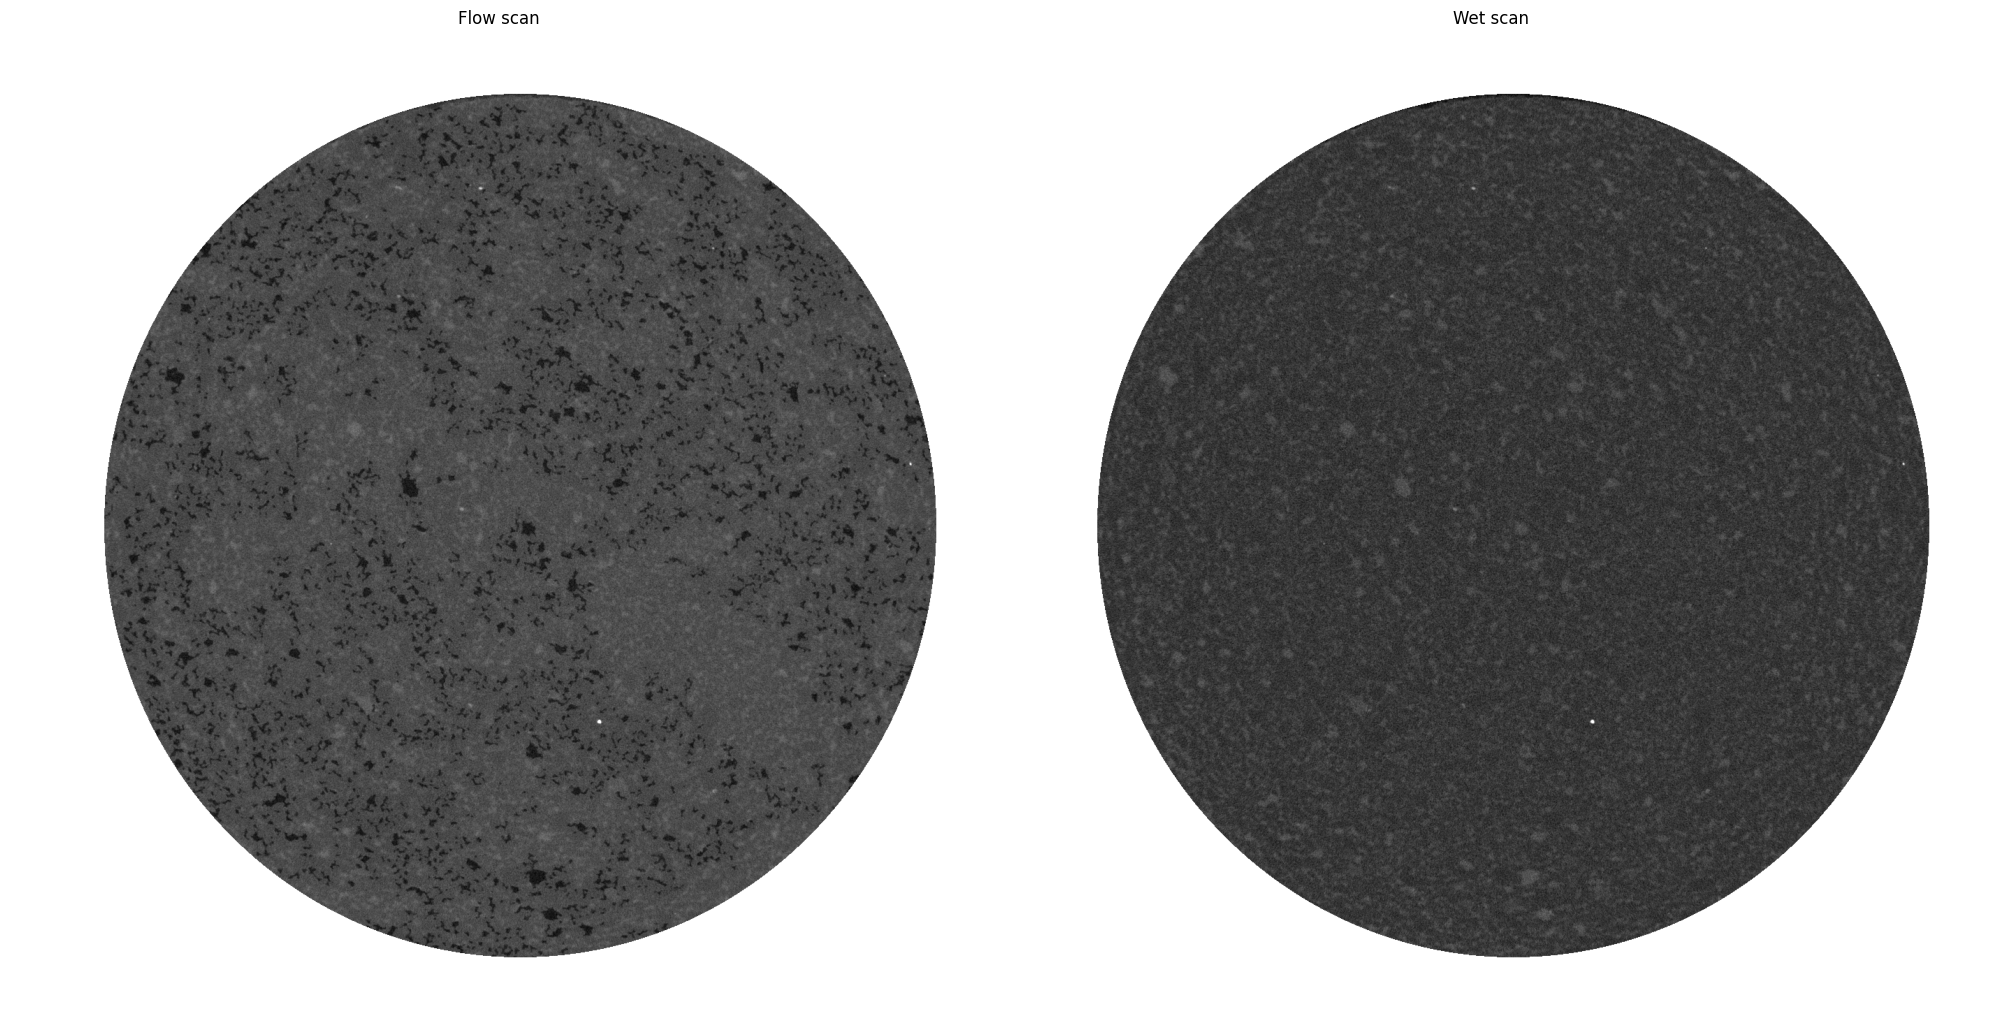

In [219]:
# The images are cropped into a cylinder (so that we aren't including the outer sleeve in the analysis) 
flow_data = crop(flow_data)
wet_data  = crop(wet_data)

#NB lots of data overwriting at this point to preserve memory 

#Check the data 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(flow_data[1, :, :],cmap='gray')
ax[0].axis('off')
ax[0].set_title('Flow scan')


ax[1].imshow(wet_data[1,:, :],cmap='gray')
ax[1].axis('off')
ax[1].set_title('Wet scan')

fig.tight_layout()
plt.show()

### Subtraction of flow scan with wet scan to perform gas segmentation with no masking 

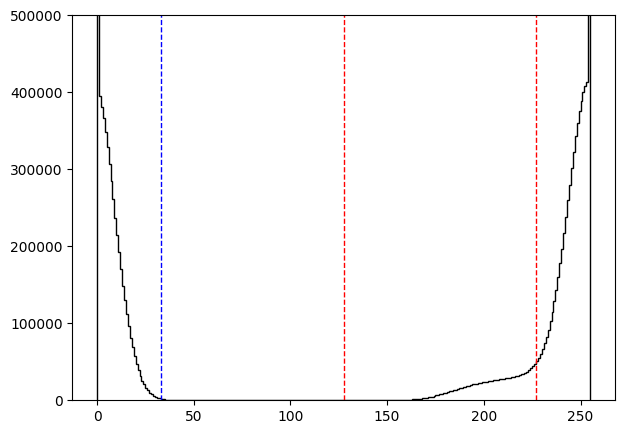

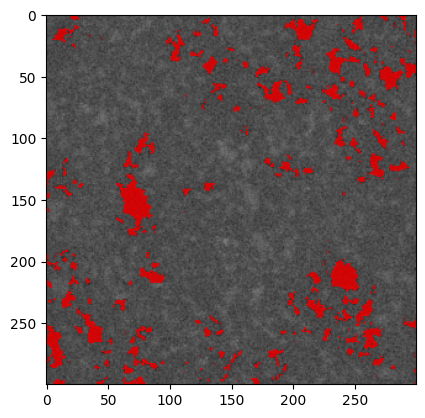

In [220]:
just_gas = flow_data - wet_data

def simple_thresholding(img: np.array, min_threshold: float, max_threshold: float) -> np.array:
    bins=255
    fig, ax = plt.subplots(figsize =(7, 5))
    ax.hist(img[:, :, :].ravel(), bins=bins, histtype='step', color='black')

    # find where histogram goes to 0 for the brine 
    hist_values = img[:, :, :].ravel()
    hist_bincount = np.bincount(hist_values)
    end_brine     = np.argmax(hist_bincount<2000)
    #max_threshold  = (255 - end_brine) / 255

    ax.set_ylim(0, 5e5)
    plt.axvline(min_threshold*img.max(), color='r', linestyle='dashed', linewidth=1)
    plt.axvline(max_threshold*img.max(), color='r', linestyle='dashed', linewidth=1)
    plt.axvline(end_brine, color='b', linestyle='dashed', linewidth=1)
    plt.show()

    threshold_img = ((img.max() - img.min()) * min_threshold + img.min() <= img) & (img <= (img.max() - img.min()) * max_threshold + img.min())
    threshold_img = np.array(threshold_img, dtype=np.bool8)

    assert len(threshold_img.shape) == 3  # rgb
    return threshold_img


gas_v1         = simple_thresholding(just_gas, min_threshold=0.5, max_threshold = 0.89) # previously 0.15 and 0.45 
filtered_gasv1 = skimage.morphology.remove_small_objects(gas_v1, min_size=3)    

seg_gas = utils.sanity_check(flow_data[3, ...], filtered_gasv1[3, ...], 0.8)
plt.imshow(seg_gas[500:800, 500:800])
plt.show()

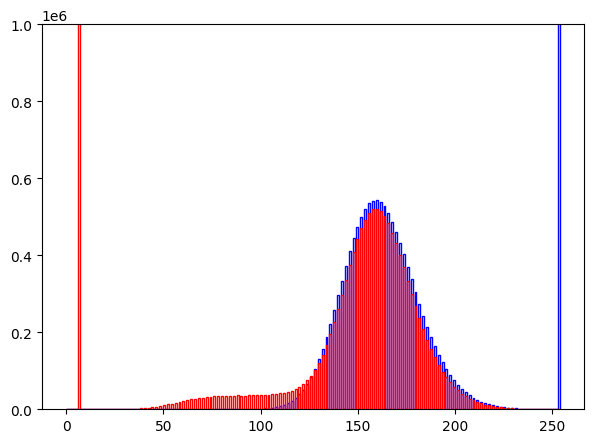

In [221]:
#quick test of histograms (so we can remove the brine)
bins=255
fig, ax = plt.subplots(figsize =(7, 5))
ax.hist(wet_data[:, :, :].ravel()*2, bins=bins, histtype='step', color='blue')
ax.hist((flow_data[:, :, :].ravel()+4) *2, bins=bins, histtype='step', color='red')
ax.set_ylim(0, 10e5)
plt.show()



### Check the segmentation was successful 

In [227]:
seg_gas = utils.sanity_check(flow_data[3, ...], filtered_gasv1[3, ...], 0.2)

z_widget = widgets.IntSlider(
    value=2,
    min=0,
    max=10,
    step=1,
)


overlay_widget = widgets.RadioButtons(
    options=[True, False],
    description='Overlay:',
    disabled=False,
)


def view_slice(img: np.ndarray, z: int, overlay: bool, mask: bool) -> None:
    depth, h, w = img.shape
    assert isinstance(img, np.ndarray)
    assert isinstance(z, int)
    assert isinstance(overlay, bool)
    assert 0 <= z < depth

    slice = img[z, :, :]

    if overlay:
        slice = utils.preprocess(slice)
        mask  = mask[z, :, :]
        slice = utils.sanity_check(slice, mask)
    fig = plt.figure(figsize=(20, 12))
    plt.imshow(slice, cmap='gray')
    plt.show()


widgets.interact(view_slice, img=widgets.fixed(flow_data[:, 500:1000,500:1000]), z=z_widget, overlay=overlay_widget, mask = widgets.fixed(filtered_gasv1[:, 500:1000,500:1000]))

interactive(children=(IntSlider(value=2, description='z', max=10), RadioButtons(description='Overlay:', option…

<function __main__.view_slice(img: numpy.ndarray, z: int, overlay: bool, mask: bool) -> None>

### Segmentation with masking from the dry scan

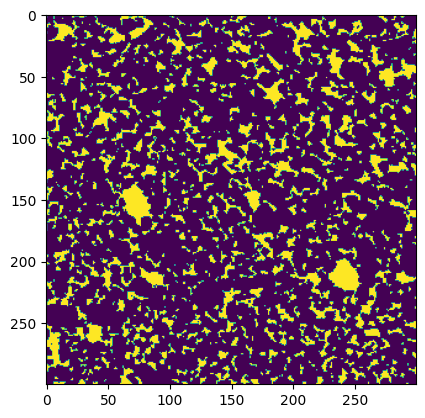

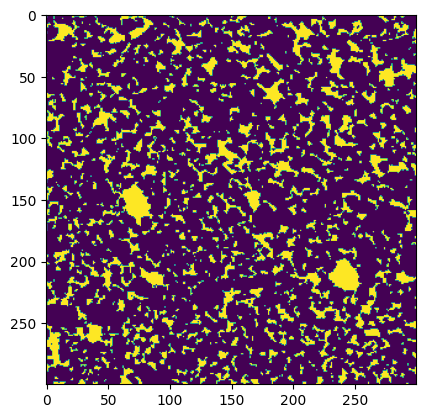

In [223]:
#load in the segmented image 

segmented_dry = skimage.io.imread('segmented_500.tif')
segmented_sub = skimage.io.imread('segmented_sub_resolved_500.tif')

plt.imshow(segmented_dry[3, 500:800, 500:800])
plt.show()

segmented_dry = segmented_dry +segmented_sub 

plt.imshow(segmented_dry[3, 500:800, 500:800])
plt.show()

In [224]:

def mask_with_dry(img, dry_scan):
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype(np.uint8)

    # creating mask from segmented dry scan
    mask = (dry_scan == 0)

    assert img.shape == mask.shape
    assert mask.dtype == np.bool8
    # mask image 
    foreground = img.copy()
    foreground[mask] = 255 

    # create a composite image using the alpha layer
    masked_img = np.array(foreground, dtype=np.uint8)
    return masked_img 

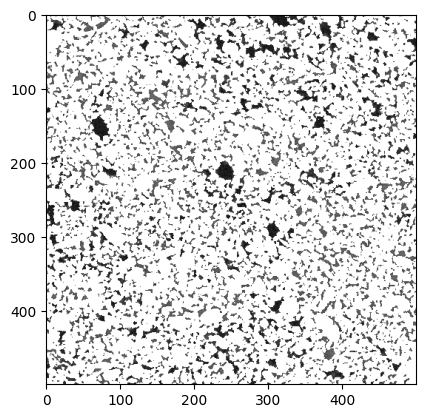

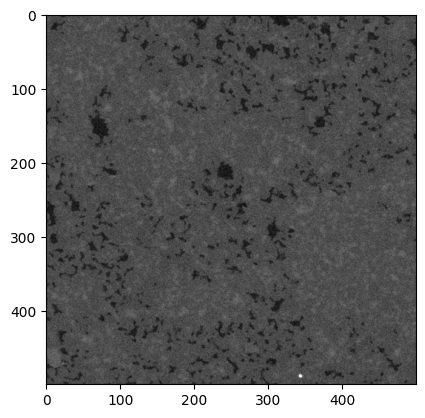

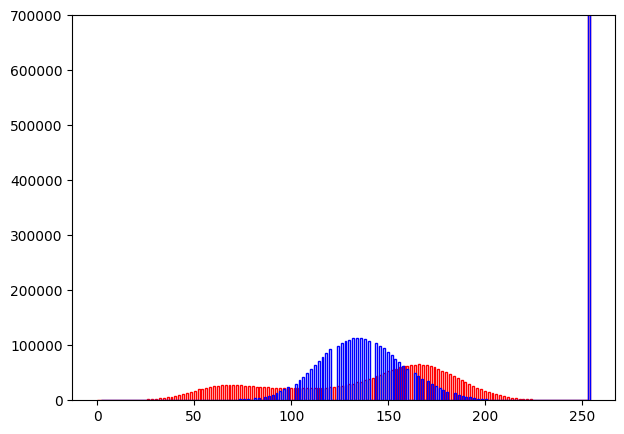

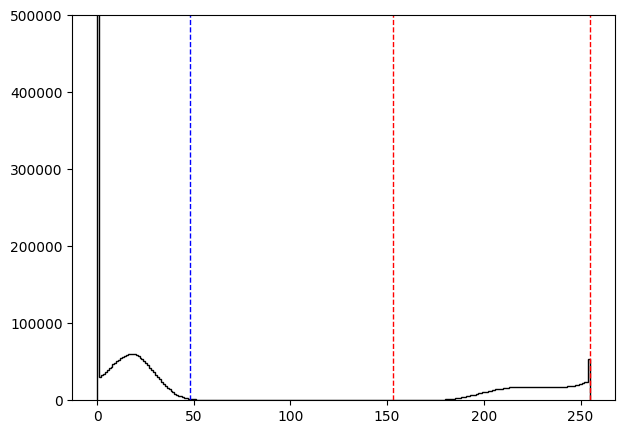

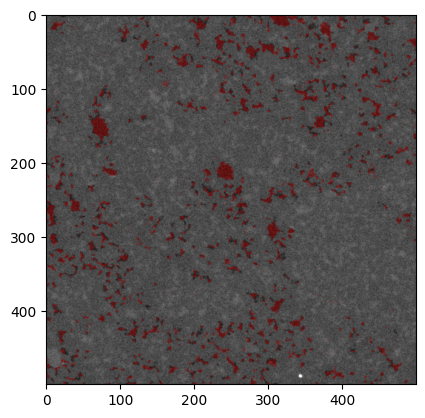

In [225]:
#currently incorrect, with segmented scan not looking like the flow data 
masked_flow =  mask_with_dry(flow_data, segmented_dry)
masked_wet  =  mask_with_dry(wet_data, segmented_dry)
masked_just_gas = masked_flow  - masked_wet

fig = figsize =(20, 20)
plt.imshow(masked_flow[3,500:1000, 500:1000], cmap= "gray")
plt.show()
fig = figsize =(20, 20)
plt.imshow(flow_data[3,500:1000, 500:1000], cmap= "gray")
plt.show()

#quick test of histograms 
bins=255
fig, ax = plt.subplots(figsize =(7, 5))
ax.hist(masked_flow.ravel()*2, bins=bins, histtype='step', color='red')
ax.hist((masked_wet.ravel()) *2, bins=bins, histtype='step', color='blue')
ax.set_ylim(0, 7e5)
plt.show()



gas_v2         = simple_thresholding(masked_just_gas, min_threshold=0.6, max_threshold = 1) # previously 0.15 and 0.45 
filtered_gasv2 = skimage.morphology.remove_small_objects(gas_v2, min_size=3)    

seg_gasv2 = utils.sanity_check(flow_data[3, ...], filtered_gasv2[3, ...], 0.3)
plt.imshow(seg_gasv2[500:1000, 500:1000])
plt.show()

### Comparison of methods

In [226]:
#change in gas saturation for the different techniques 
x = 100* (np.count_nonzero(filtered_gasv1==1) - np.count_nonzero(filtered_gasv2==1)) / (0.5* (np.count_nonzero(filtered_gasv1==1) + np.count_nonzero(filtered_gasv2==1)))
print('The percentage differnce in gas saturation is', '%.1f' % x, '%')


#change in connectivity for the different techniques 

all_labelsv1 = skimage.measure.label(filtered_gasv1, background = 0)
all_labelsv2 = skimage.measure.label(filtered_gasv2, background = 0)


y = 100* (all_labelsv2.max() - all_labelsv1.max()) / (0.5* (all_labelsv1.max() + all_labelsv2.max()))
print('The percentage differnce in gas connectivity is', '%.1f' % y, '%')





The percentage differnce in gas saturation is 16.5 %
The percentage differnce in gas connectivity is 61.3 %
